# Project Two Code 

In [1]:
import numpy as np
import nltk
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
from sklearn.linear_model import LogisticRegression
from transformers import pipeline

C:\Users\Nadya\anaconda3\envs\ECON1680\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Web Scraping NYT Articles Using NYT API 

In [2]:
import requests as req
import time
API_KEY='9kiWZKsGFtTkcTD4yYkyxWAKehiTKkzR' # your API key

In [3]:
import calendar

# Create an empty list to store articles
articles2 = []

# Loop through every month from Jan 2020 to Feb 2024
for year in range(2020, 2024):
    for month in range(1, 13):
        # Calculate the number of days in the current month
        num_days = calendar.monthrange(year, month)[1]

        # Construct the begin_date and end_date parameters for the query
        begin_date = f"{year:04d}-{month:02d}-01"
        end_date = f"{year:04d}-{month:02d}-{num_days:02d}"

        # Loop through 5 pages (max 10 results per page, hence 50 articles)
        for i in range(5):
            # Sleep to avoid exceeding the API rate limit
            time.sleep(10)
            try:
                # Construct the URL
                url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q=artificial+intelligence&api-key={API_KEY}&sort=relevance&begin_date={begin_date}&end_date={end_date}&page={i+1}'

                # Make the request and get the response
                response = req.get(url).json()
                # Extract relevant information from the response and append to articles list
                docs = response['response']['docs']
                for doc in docs:
                    filteredDoc = {}
                    filteredDoc['title'] = doc['headline']['main']
                    filteredDoc['abstract'] = doc['abstract']
                    filteredDoc['paragraph'] = doc['lead_paragraph']
                    filteredDoc['date'] = f"{year}-{month:02d}"
                    articles2.append(filteredDoc)
                
                
            except KeyError as e:
                print(f"No response while processing page {i+1} for {begin_date} - {end_date}: {e}")


No response while processing page 3 for 2020-02-01 - 2020-02-29: 'response'
No response while processing page 4 for 2020-04-01 - 2020-04-30: 'response'
No response while processing page 5 for 2020-07-01 - 2020-07-31: 'response'
No response while processing page 1 for 2020-11-01 - 2020-11-30: 'response'
No response while processing page 2 for 2021-01-01 - 2021-01-31: 'response'
No response while processing page 3 for 2021-04-01 - 2021-04-30: 'response'
No response while processing page 4 for 2021-06-01 - 2021-06-30: 'response'
No response while processing page 5 for 2021-09-01 - 2021-09-30: 'response'
No response while processing page 1 for 2022-01-01 - 2022-01-31: 'response'
No response while processing page 2 for 2022-03-01 - 2022-03-31: 'response'
No response while processing page 3 for 2022-06-01 - 2022-06-30: 'response'
No response while processing page 4 for 2022-08-01 - 2022-08-31: 'response'
No response while processing page 5 for 2022-11-01 - 2022-11-30: 'response'
No response 

In [4]:
nyt_ai2 = pd.DataFrame(data=articles2)

In [5]:
nyt_ai2.shape

(1370, 4)

#### Note: 1370 articles in total means an average of ~28-29 articles scraped per month 

In [7]:
nyt_ai2.to_csv('r2_scraped_nyt.csv')

## Text Upload

In [2]:
nyt_data = pd.read_csv('r2_scraped_nyt.csv')

In [3]:
nyt_data.drop(columns=['Unnamed: 0'])

,title,abstract,paragraph,date
0,Soon a Robot Will Be Writing This Headline,"In “A World Without Work,” the economist Danie...","A WORLD WITHOUT WORK Technology, Automation, a...",2020-01
1,A.I. Comes to the Operating Room,Images made by lasers and read by computers ca...,Brain surgeons are bringing artificial intelli...,2020-01
2,Confessions of a Dating Profile,"My boss’s demands were very, very persuasive, ...","My boss’s demands were very, very persuasive, ...",2020-01
3,"Lesson of the Day: ‘The Machines Are Learning,...","In this lesson, students will learn about how ...","Featured Article: “The Machines Are Learning, ...",2020-01
4,Facebook Says It Will Ban ‘Deepfakes’,The company said it would remove videos altere...,WASHINGTON — Facebook says it will ban videos ...,2020-01
...,...,...,...,...
1365,Cities Foster Serendipity. But Can They Do It ...,Revisiting a theory about chance collisions an...,There is a thing that happens in cities — that...,2023-10
1366,Allied Spy Chiefs Warn of Chinese Espionage Ta...,F.B.I. officials say more than half of Chinese...,The United States and its allies vowed this we...,2023-10
1367,Researchers Say Guardrails Built Around A.I. S...,OpenAI now lets outsiders tweak what its chatb...,Before it released the A.I. chatbot ChatGPT la...,2023-10
1368,An Industry Insider Drives an Open Alternative...,"The nonprofit Allen Institute for AI, led by a...",Ali Farhadi is no tech rebel.,2023-10


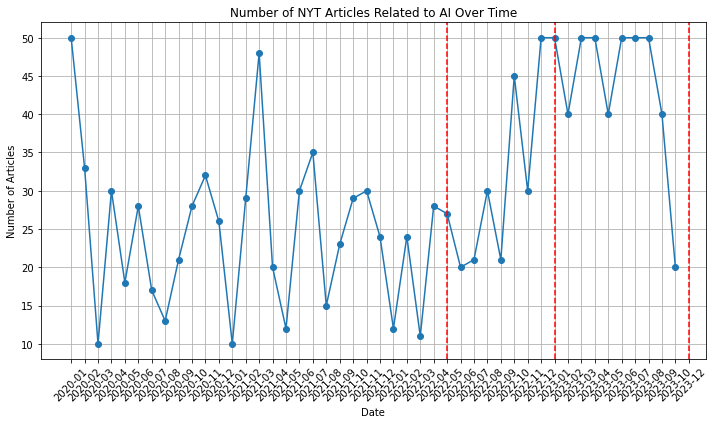

In [4]:
# Count the number of articles for each date
article_counts_by_date = nyt_data['date'].value_counts().sort_index()

# Plot the number of articles over time
plt.figure(figsize=(10, 6))
plt.plot(article_counts_by_date.index, article_counts_by_date.values, marker='o', linestyle='-')
plt.title('Number of NYT Articles Related to AI Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at the start, peak and end of tech layoffs
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2022-05', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-12', color='r', linestyle='--', label='2023-11')
plt.show()

In [5]:
layoffs_data = pd.read_csv('layoffs_data(3).csv')

In [9]:
layoffs_data.head()

,Company,Location_HQ,Industry,Percentage,Date,Source,Funds_Raised,Stage,Date_Added,Country,Laid_Off_Count,List_of_Employees_Laid_Off
0,Fisker,Los Angeles,Transportation,0.15,2024-02-29,https://techcrunch.com/2024/02/29/fisker-layof...,1700.0,Post-IPO,2024-02-29 23:35:20,United States,NaN,Unknown
1,Electronic Arts,SF Bay Area,Consumer,0.05,2024-02-28,https://www.cnbc.com/2024/02/28/ea-layoffs-com...,2.0,Post-IPO,2024-02-29 00:45:00,United States,670.0,Unknown
2,Vacasa,Portland,Travel,0.05,2024-02-28,https://www.oregonlive.com/business/2024/02/po...,834.0,Post-IPO,2024-02-29 17:22:37,United States,320.0,Unknown
3,Treasury Prime,SF Bay Area,Finance,0.40,2024-02-28,https://www.bankingdive.com/news/treasury-prim...,71.0,Series C,2024-02-29 00:48:03,United States,40.0,Unknown
4,Motional,Boston,Transportation,0.05,2024-02-28,https://techcrunch.com/2024/02/28/hyundai-back...,NaN,Unknown,2024-02-28 18:50:58,United States,NaN,Unknown


In [43]:
# Convert 'date' column to datetime
layoffs_data['Date'] = pd.to_datetime(layoffs_data['Date'])

# Convert 'date' column to 'YYYY-MM' format
layoffs_data['Date'] = layoffs_data['Date'].dt.strftime('%Y-%m')

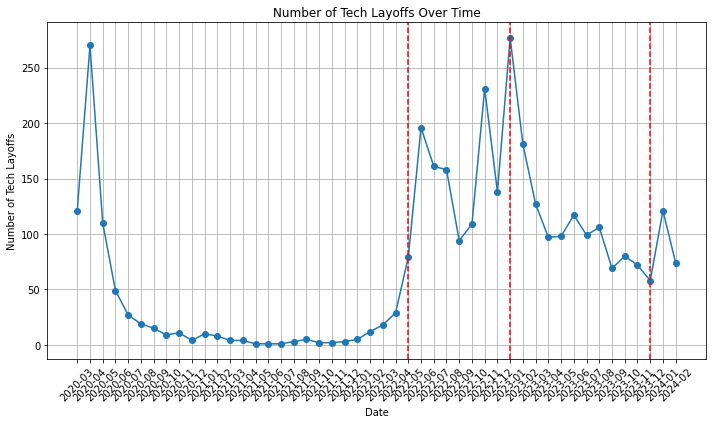

In [56]:
# Count the number of layoffs for each date
layoffs_counts_by_date = layoffs_data['Date'].value_counts().sort_index()
# Plot the number of layoffs over time
plt.figure(figsize=(10, 6))
plt.plot(layoffs_counts_by_date.index, layoffs_counts_by_date.values, marker='o', linestyle='-')
plt.title('Number of Tech Layoffs Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tech Layoffs')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2022-05', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-12', color='r', linestyle='--', label='2023-11')
plt.show()

## Preliminary Sentiment Analysis 

### Using Transfer-Learning Methods

#### Using Default DistilBERT Model

In [40]:
# Initiate a pipeline with the default sentiment analysis model
sentiment_pipeline = pipeline("sentiment-analysis")

# Convert paragraphs to strings
nyt_data['abstract'] = nyt_data['abstract'].astype(str)

# Function to calculate sentiment score
def calculate_sentiment_score(paragraph):
    # Perform sentiment analysis on the paragraph
    sentiment = sentiment_pipeline(paragraph)[0]
    
    # If sentiment is negative, return -1 * score
    if sentiment['label'] == 'NEGATIVE':
        return -1 * sentiment['score']
    # If sentiment is positive, return +1 * score
    elif sentiment['label'] == 'POSITIVE':
        return sentiment['score']
    else:
        return None

# Apply the function to each row and create a new column 'sentiment_score'
nyt_data['distilbert_sentiment_score'] = nyt_data['paragraph'].apply(calculate_sentiment_score)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


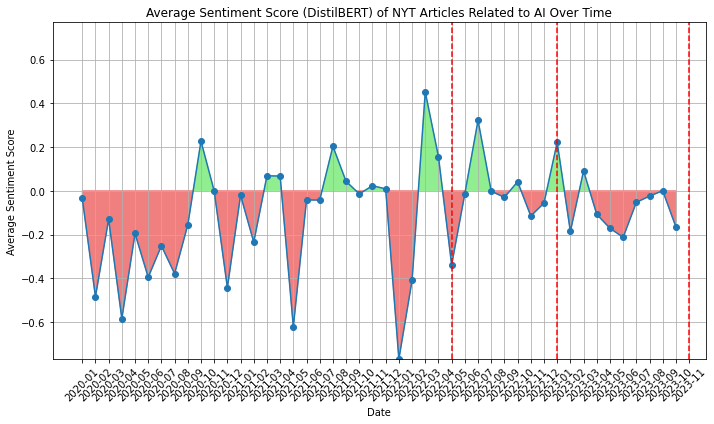

In [41]:
# Group by date and calculate average sentiment score
average_sentiment_by_date = nyt_data.groupby('date')['distilbert_sentiment_score'].mean()

# Plot the time-wise graph
plt.figure(figsize=(10, 6))
# Plot above zero values with green background
plt.fill_between(average_sentiment_by_date.index, average_sentiment_by_date.values, 0, where=average_sentiment_by_date.values >= 0, color='lightgreen', interpolate=True)

# Plot below zero values with red background
plt.fill_between(average_sentiment_by_date.index, average_sentiment_by_date.values, 0, where=average_sentiment_by_date.values <= 0, color='lightcoral', interpolate=True)

plt.plot(average_sentiment_by_date.index, average_sentiment_by_date.values, marker='o', linestyle='-')
plt.title('Average Sentiment Score (DistilBERT) of NYT Articles Related to AI Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2022-05', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-11', color='r', linestyle='--', label='2023-11')

# Set y-axis limit to include 0 and center the graph at y=0
max_abs_score = max(abs(average_sentiment_by_date.min()), abs(average_sentiment_by_date.max()))
plt.ylim(-max_abs_score, max_abs_score)

plt.show() 

In [42]:
# Generate a dummy variable for positive/ negative 
nyt_data['distilbert_sentiment_dummy'] = nyt_data['distilbert_sentiment_score'].apply(lambda x: 1 if x > 0 else 0)

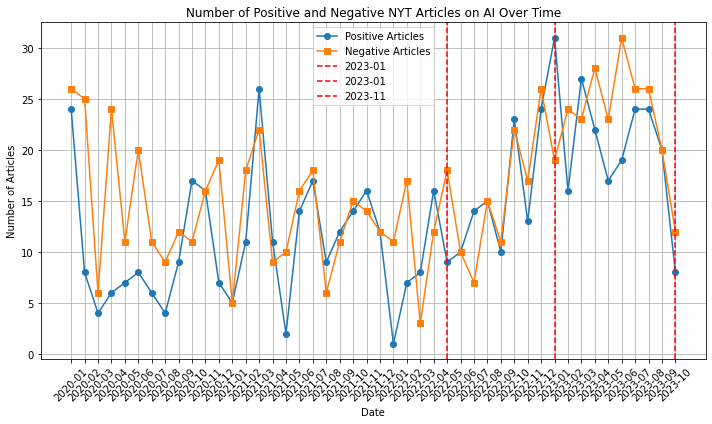

In [43]:
# Graph number of positive articles over time AND number of negative articles over time (two lines)
positive_articles = nyt_data[nyt_data['distilbert_sentiment_dummy'] == 1].groupby('date').size()
negative_articles = nyt_data[nyt_data['distilbert_sentiment_dummy'] == 0].groupby('date').size()

plt.figure(figsize=(10, 6))
plt.plot(positive_articles.index, positive_articles.values, label='Positive Articles', marker='o')
plt.plot(negative_articles.index, negative_articles.values, label='Negative Articles', marker='s')

plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2022-05', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-10', color='r', linestyle='--', label='2023-11')

plt.title('Number of Positive and Negative NYT Articles on AI Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

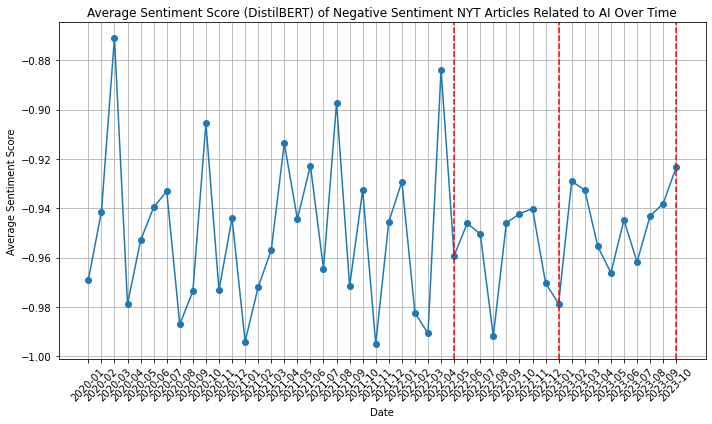

In [44]:
# Filter negative articles
negative_articles = nyt_data[nyt_data['distilbert_sentiment_dummy'] == 0]

# Group by date and calculate average sentiment score
average_sentiment_by_date = negative_articles.groupby('date')['distilbert_sentiment_score'].mean()

# Plot the time-wise graph
plt.figure(figsize=(10, 6))
plt.plot(average_sentiment_by_date.index, average_sentiment_by_date.values, marker='o', linestyle='-')
plt.title('Average Sentiment Score (DistilBERT) of Negative Sentiment NYT Articles Related to AI Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2022-05', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-10', color='r', linestyle='--', label='2023-11')
plt.show()

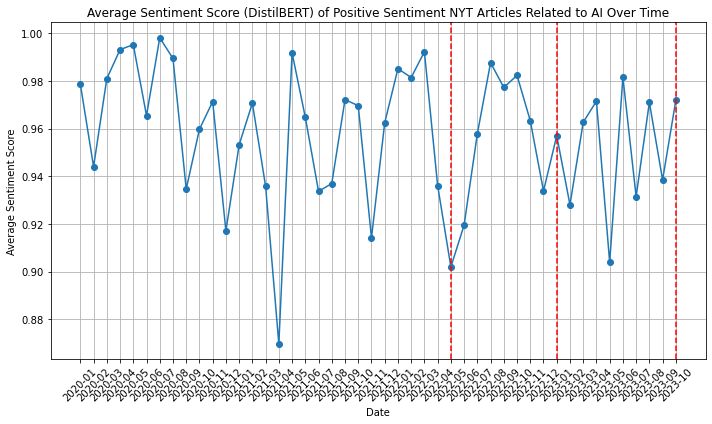

In [45]:
# Filter positive articles
positive_articles = nyt_data[nyt_data['distilbert_sentiment_dummy'] == 1]

# Group by date and calculate average sentiment score
average_sentiment_by_date = positive_articles.groupby('date')['distilbert_sentiment_score'].mean()

# Plot the time-wise graph
plt.figure(figsize=(10, 6))
plt.plot(average_sentiment_by_date.index, average_sentiment_by_date.values, marker='o', linestyle='-')
plt.title('Average Sentiment Score (DistilBERT) of Positive Sentiment NYT Articles Related to AI Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2022-05', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-10', color='r', linestyle='--', label='2023-11')
plt.show()

### Using Lexicon-Based Methods 

## Other links to employment - which articles mention employment? What are the sentiment paths of these articles? Which words are most predictive of these articles? What are the sentiments of these words?

#### Data Cleaning

In [46]:
import re
# create an empty list for clean paragraphs 
cleanabstract=[]
# for each rows in the df 
for i in range(len(nyt_data)):
    # replace unwanted characters 
    para=str(nyt_data['abstract'].iloc[i])
    para=para.replace('\r',' ')
    para=para.replace('\n',' ')
    para=para.replace('. ',' ')
    para=para.replace(', ',' ')
    # remove special characters
    para=re.sub('[^A-Za-z]+', ' ', para)
    # lowercase 
    cleanabstract.append(para.lower())
nyt_data['clean abstract']= cleanabstract

In [51]:
# Define employment-related keywords
employment_keywords = ['employment', 'jobs', 'job', 'occupation', 'work', 'trade', 'profession']

# Function to check if paragraph contains employment-related keywords
def contains_employment_keywords(paragraph):
    for keyword in employment_keywords:
        if keyword in paragraph:
            return 1
    return 0

# Create dummy variable indicating whether employment-related keywords are mentioned
nyt_data['mentions_employment'] = nyt_data['clean abstract'].apply(contains_employment_keywords)


In [52]:
employment_mentions_nyt = nyt_data[nyt_data['mentions_employment'] == 1]


In [53]:
employment_mentions_nyt.shape

(145, 13)

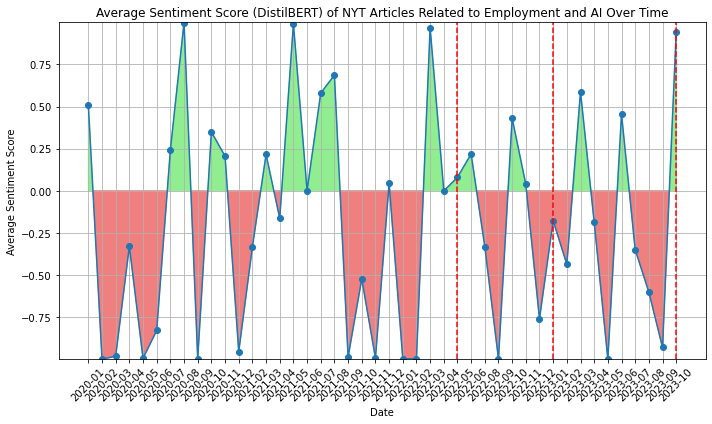

In [54]:
# Group by date and calculate average sentiment score
average_sentiment_by_date = employment_mentions_nyt.groupby('date')['distilbert_sentiment_score'].mean()

# Plot the time-wise graph
plt.figure(figsize=(10, 6))

# Plot above zero values with green background
plt.fill_between(average_sentiment_by_date.index, average_sentiment_by_date.values, 0, where=average_sentiment_by_date.values >= 0, color='lightgreen', interpolate=True)

# Plot below zero values with red background
plt.fill_between(average_sentiment_by_date.index, average_sentiment_by_date.values, 0, where=average_sentiment_by_date.values <= 0, color='lightcoral', interpolate=True)

# Plot the line
plt.plot(average_sentiment_by_date.index, average_sentiment_by_date.values, marker='o', linestyle='-')

plt.title('Average Sentiment Score (DistilBERT) of NYT Articles Related to Employment and AI Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2022-05', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-10', color='r', linestyle='--', label='2023-11')

# Set y-axis limit to include 0 and center the graph at y=0
max_abs_score = max(abs(average_sentiment_by_date.min()), abs(average_sentiment_by_date.max()))
plt.ylim(-max_abs_score, max_abs_score)

plt.show()

### Logit-lasso regression

In [ ]:
# Do this for sentiment 

In [55]:
# Loop through each row in 'clean paragraph' to remove employment-related keywords
for index, paragraph in enumerate(nyt_data['clean abstract']):
    for keyword in employment_keywords:
        paragraph = paragraph.replace(keyword, '')
        nyt_data.at[index, 'clean abstract no employment'] = paragraph

In [56]:
vectorizer = TfidfVectorizer()

# Fit and transform the clean paragraph list to create the document-term matrix
X = vectorizer.fit_transform(nyt_data['clean abstract no employment'])

In [57]:
# Convert binary sentiment column to array y
y = nyt_data['mentions_employment'].to_numpy()

# Convert document term matrix to array X
x = X.toarray() 

In [58]:
features = vectorizer.get_feature_names()

C:\Users\Nadya\anaconda3\envs\ECON1680\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [59]:

# Values of C to consider
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Initialize variables to store maximum accuracy and corresponding C value
max_accuracy = 0
best_C = None

# Loop over different values of C
for C in C_values:
    # Create and fit the logistic regression model
    model = LogisticRegression(penalty='l1', solver='liblinear', random_state=1680, C=C)
    model.fit(x, y)
    
    # Calculate accuracy
    accuracy = model.score(x, y)
    
    # Check if this accuracy is the highest so far
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_C = C

print("Best C value:", best_C)

Best C value: 10


In [60]:
model = LogisticRegression(penalty='l1', solver='liblinear', random_state=1680, C=best_C)
model.fit(x, y)

# Save model coefficients as "coefs"
coefs = model.coef_

In [61]:
# create a new dataframe with words and their assigned coefficients 
df_coef = pd.DataFrame({'word': features, 'coef': coefs[-1].tolist()}) 
# absolute value of coefficients 
df_coef['abs coef']= df_coef['coef'].abs()

In [62]:
# Sort DataFrame by absolute values of coefficients
df_coef_sorted = df_coef.sort_values(by='abs coef', ascending=False)

# Get top 50 most predictive words of mentions of employment
df_coef_sorted.head(50)

,word,coef,abs coef
1798,ers,38.089018,38.089018
2676,ing,32.048840,32.048840
3458,net,29.449366,29.449366
2101,force,25.436453,25.436453
3461,nets,23.469253,23.469253
321,artistic,23.072464,23.072464
5336,trauma,19.510740,19.510740
3460,neting,19.398896,19.398896
4571,sculptor,18.475360,18.475360
4259,regulator,14.031628,14.031628


In [63]:
nyt_data.head()

,Unnamed: 0,title,abstract,paragraph,date,distilbert_sentiment_score,distilbert_sentiment_dummy,clean paragraph,mentions_employment,clean paragraph no employment,clean abstract,POS tagged,SWN analysis,clean abstract no employment
0,0,Soon a Robot Will Be Writing This Headline,"In “A World Without Work,” the economist Daniel Susskind argues that, unlike during past technological shifts, machines really are becoming smart enough to take over our jobs.","A WORLD WITHOUT WORK Technology, Automation, and How We Should RespondBy Daniel Susskind",2020-01,0.891256,1,a world without work technology automation and how we should respondby daniel susskind,1,a world without technology automation and how we should respondby daniel susskind,in a world without work the economist daniel susskind argues that unlike during past technological shifts machines really are becoming smart enough to take over our jobs,"[(world, n), (without, None), (work, n), (economist, n), (daniel, n), (susskind, n), (argues, v), (unlike, None), (past, a), (technological, a), (shifts, n), (machines, n), (really, r), (becoming, v), (smart, r), (enough, r), (take, v), (jobs, n)]",0.500,in a world without the economist daniel susskind argues that unlike during past technological shifts machines really are becoming smart enough to take over our
1,1,A.I. Comes to the Operating Room,Images made by lasers and read by computers can help speed up the diagnosis of brain tumors during surgery.,"Brain surgeons are bringing artificial intelligence and new imaging techniques into the operating room, to diagnose tumors as accurately as pathologists, and much faster, according to a report in the journal Nature Medicine.",2020-01,0.991159,1,brain surgeons are bringing artificial intelligence and new imaging techniques into the operating room to diagnose tumors as accurately as pathologists and much faster according to a report in the journal nature medicine,0,brain surgeons are bringing artificial intelligence and new imaging techniques into the operating room to diagnose tumors as accurately as pathologists and much faster according to a report in the journal nature medicine,images made by lasers and read by computers can help speed up the diagnosis of brain tumors during surgery,"[(images, n), (made, v), (lasers, n), (read, v), (computers, n), (help, v), (speed, v), (diagnosis, n), (brain, n), (tumors, n), (surgery, n)]",0.250,images made by lasers and read by computers can help speed up the diagnosis of brain tumors during surgery
2,2,Confessions of a Dating Profile,"My boss’s demands were very, very persuasive, appealing to the deep human need to share and be seen. I know because I wrote them.","My boss’s demands were very, very persuasive, appealing to the deep human need to share and be seen. I know because I wrote them.",2020-01,0.998428,1,my boss s demands were very very persuasive appealing to the deep human need to share and be seen i know because i wrote them,0,my boss s demands were very very persuasive appealing to the deep human need to share and be seen i know because i wrote them,my boss s demands were very very persuasive appealing to the deep human need to share and be seen i know because i wrote them,"[(boss, n), (demands, n), (persuasive, a), (appealing, v), (deep, a), (human, a), (need, n), (share, n), (seen, v), (know, v), (wrote, v)]",-0.125,my boss s demands were very very persuasive appealing to the deep human need to share and be seen i know because i wrote them
3,3,"Lesson of the Day: ‘The Machines Are Learning, and So Are the Students’","In this lesson, students will learn about how A.I. is changing education and imagine how the machine learning revolution will shape the schools of the future.","Featured Article: “The Machines Are Learning, and So Are the Students” by Craig S. Smith",2020-01,0.984134,1,featured article the machines are learning and so are the students by craig s smith,0,featured article the machines are learning and so are the students by 